# Classical Portfolio Optimization

This notebook is used to generate a portfolio of 10 random stocks from the AlphaVantage API and then optimize the portfolio weights using Markowitz theory. The optimization analysis can be performed using 3 years of historical stock data (2014-2017). 

The returns of the portfolio with and without optimization over a 3 year test timeframe can then be calculated (2017-2020). These results will be used as the baseline in which the optimization performed through supervised and unsupervised learning will be compared.

In order to perform the optimization, the stock data must be obtained, the **expected returns** must be calculated, the **variance** of the stock data must be calculated and the **effecient frontier** must be found.


## Obtaining stock data



### Getting stock names
The stock names can be found by obtaining an array of all the stocks in the S&P 500 index, generating 10 random numbers and then using those numbers to choose 10 array items.

In [44]:
#Taken from Automating getting the S&P 500 list - Python Programming for Finance p.5
# https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/

import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.strip("\n"))
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

save_sp500_tickers()
    

['MMM',
 'ABT',
 'ABBV',
 'ABMD',
 'ACN',
 'ATVI',
 'ADBE',
 'AMD',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALXN',
 'ALGN',
 'ALLE',
 'AGN',
 'ADS',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'T',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AIV',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ARNC',
 'ANET',
 'AJG',
 'AIZ',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BLL',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BRK.B',
 'BBY',
 'BIIB',
 'BLK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BF.B',
 'CHRW',
 'COG',
 'CDNS',
 'CPB',
 'COF',
 'CPRI',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CTL',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

Next 10 random numbers between 0 and 504 can be generated in order to pick 10 random stock tickers from the list

In [45]:
import random

tickers = save_sp500_tickers()
print(len(tickers)) # there are actually 505 stocks in the S&P 500, who knew!

def getRandomTickers(tickers):
  randIndex = []
  randTickers = []
  for i in range(0,10):
    randIndex.append(random.randint(0,504))
  for index in randIndex:
    randTickers.append(tickers[index])
  return randTickers

print(getRandomTickers(tickers)) 


505
['IR', 'VFC', 'FRT', 'KMI', 'APA', 'COO', 'CHRW', 'EA', 'INTU', 'EIX']


Now we can get the names of the tickers in the dataset. 

The data was extracted from the API using a NodeJS program which obtained daily price and volume data for each stock over a period of 20 years. Due to the failure to extract data for several stocks, the number of stock tickers is not exactly 505, but rather close to 500.

We first need to import the data from the csv into a pandas dataframe so that it can be further analyzed.

The data is stored in Google Drive and can be accessed via Colab after mounting to Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now the csv can be imported into a dataframe


In [46]:
import pandas as pd
import time

#change directory to where the data is located 
# %cd drive/My Drive/cap4770-project
!pwd

#use timer to get process times
start_time = time.time()

#read csv
data = pd.read_csv("SP_DAILY_2000-2020.csv")
print("read data --- %s seconds ---" % (time.time() - start_time))
print()

#preview first 5 lines
start_time = time.time()
print(data.head())
print("get head --- %s seconds ---" % (time.time() - start_time))
print()

#preview last 5 lines
start_time = time.time()
print(data.tail())
print("get tail --- %s seconds ---" % (time.time() - start_time))
print()

#get size
start_time = time.time()
print("Size:", data.size)
print("get size --- %s seconds ---" % (time.time() - start_time))
print()

/content
read data --- 1.6866998672485352 seconds ---

  Symbol        Date    Open   Close     High     Low   Volume
0    MMM  2020-03-26  131.79  135.98  136.355  130.61  5476351
1    MMM  2020-03-25  133.15  131.54  134.690  126.80  7732467
2    MMM  2020-03-24  122.29  132.72  133.450  121.00  9304832
3    MMM  2020-03-23  128.16  117.87  128.400  114.04  7920348
4    MMM  2020-03-20  138.07  124.89  139.240  122.71  9582251
get head --- 0.011272668838500977 seconds ---

        Symbol        Date   Open  Close   High    Low    Volume
2250258    ZTS  2013-02-07  31.00  32.00  32.73  31.00   3800800
2250259    ZTS  2013-02-06  30.98  31.03  31.43  30.75   2126100
2250260    ZTS  2013-02-05  31.25  31.04  31.98  30.85   5013200
2250261    ZTS  2013-02-04  31.09  31.02  31.99  30.76   7695400
2250262    ZTS  2013-02-01  31.50  31.01  31.74  30.47  66789100
get tail --- 0.009701728820800781 seconds ---

Size: 15751841
get size --- 0.0003464221954345703 seconds ---



Markowitz Analysis requires a vector of expected returns over the period of analysis for all of the stocks in the portfolio as well as the cauculation of the covariance matrix for the stocks. This can then be used to generate the portfolio weight vector omega.

The ffn library will be used to retrieve data for the random tickers generated from yahoo finance from March 26, 2010 to March 26, 2015.Then the preliminary Markowitz analysis can be conducted


In [47]:
#setup
%matplotlib inline

#need to add these packages to requirements.txt
!pip install empyrical ffn PyPortfolioOpt

#taken from https://github.com/Poseyy/MarketAnalysis/blob/master/portfolios/PortfolioAnalysis.ipynb
import ffn 
from empyrical import alpha_beta
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
import matplotlib as pyplot
import numpy as np
import pandas as pd

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
  Created wheel for empyrical: filename=empyrical-0.5.3-cp36-none-any.whl size=37087 sha256=6cfb2978141a596968235178fb293fec4b6f52912c32a5750d460769446c1971
  Stored in directory: /root/.cache/pip/wheels/10/a4/3b/951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22814 sha256=4192807b9fff21eed6dfbc9c5e97c1ed0c085221d3bcc6aff49a6d26a761c5ff
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built empyrical ffn


/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


In [0]:
#generate random portfolio
randomTickers = getRandomTickers(tickers)

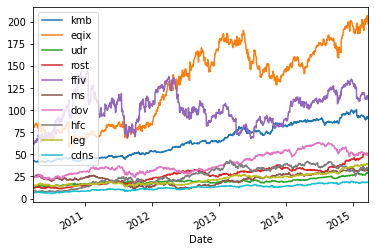

In [49]:
#retrieve price data for training period, plot data

prices = ffn.get(randomTickers,start='2010-03-26', end='2015-03-26')
ax = prices.plot()

Now we can plot the returns for this portfolio

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

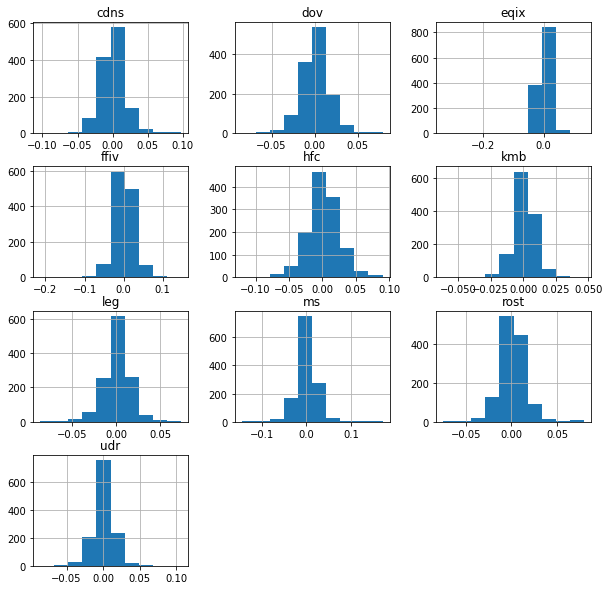

In [50]:
returns = prices.to_returns().dropna()
ax = returns.hist(figsize=(10,10))

In [51]:
#display stats for the portfolio
stats = prices.calc_stats()
stats.display()

/usr/local/lib/python3.6/dist-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Stat                 kmb         eqix        udr         rost        ffiv        ms          dov         hfc         leg         cdns
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-03-26  2010-03-26  2010-03-26  2010-03-26  2010-03-26  2010-03-26  2010-03-26  2010-03-26  2010-03-26  2010-03-26
End                  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26  2015-03-26
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         113.31%     147.29%     125.99%     307.98%     79.40%      30.01%      110.19%     298.40%     157.62%     171.90%
Daily Sharpe         1.14        0.72        0.80        1.35        0.49        0.33        0.69        0.90        0.89        0.86
Daily Sortino        1.84        1.10  

Calculate mean expected returns and covariance matrix for the price data (as per defaults specified in the PyPortfolioOpt docs https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html )

In [52]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(prices)
S = CovarianceShrinkage(prices).ledoit_wolf()
print("Mean expected returns: \n")
print(mu, "\n")
print("Covariance matrix: \n")
print(S, "\n")

Mean expected returns: 

kmb     0.161956
eqix    0.240318
udr     0.192192
rost    0.307724
ffiv    0.206836
ms      0.125976
dov     0.184493
hfc     0.353524
leg     0.220479
cdns    0.239578
dtype: float64 

Covariance matrix: 

           kmb      eqix       udr  ...       hfc       leg      cdns
kmb   0.021507  0.011336  0.012356  ...  0.011589  0.015953  0.011754
eqix  0.011336  0.111884  0.030433  ...  0.035134  0.034877  0.039869
udr   0.012356  0.030433  0.058240  ...  0.035765  0.033012  0.031174
rost  0.009553  0.022952  0.020266  ...  0.021982  0.022400  0.021249
ffiv  0.011199  0.059702  0.034247  ...  0.051496  0.042550  0.054175
ms    0.017768  0.044924  0.045918  ...  0.053991  0.050795  0.052802
dov   0.014176  0.038284  0.034908  ...  0.049216  0.042288  0.040770
hfc   0.011589  0.035134  0.035765  ...  0.151751  0.037045  0.039802
leg   0.015953  0.034877  0.033012  ...  0.037045  0.062078  0.035204
cdns  0.011754  0.039869  0.031174  ...  0.039802  0.035204  0.0786

Perform efficient frontier optimization using the max-sharpe ratio as the optimization parameter

In [53]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

#calculate efficient frontier
ef = EfficientFrontier(mu, S)

"""
use gamma parameter to reduce tendency of optimization to result in 0 asset weights, 
as this is detrimental to portfolio diversication

https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html#l2-regularisation

"""
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
weights = ef.max_sharpe()

#use cleaned weights function to round data
cleaned_weights = ef.clean_weights()

#ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

#print expected performance
ef.portfolio_performance(verbose=True)

{'kmb': 0.15636, 'eqix': 0.09254, 'udr': 0.06881, 'rost': 0.29121, 'ffiv': 0.00208, 'ms': 0.0, 'dov': 0.00677, 'hfc': 0.17926, 'leg': 0.0929, 'cdns': 0.11006}
Expected annual return: 26.2%
Annual volatility: 17.7%
Sharpe Ratio: 1.37


/usr/local/lib/python3.6/dist-packages/pypfopt/efficient_frontier.py:178: UserWarning: max_sharpe transforms the optimisation problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimisation problem so additional objectives may not work as expected."


(0.2623045919687662, 0.17708446377101048, 1.3682995493161527)

Now that the weights have been generated for the portfolio, 
the weighted and unweighted portfolio performance can be tested over the period of 2015-2020. The performance of the two portfolios can be compared to determine if the optimization indeed will improve returns.

The annualized returns of the weighted portfolio can also be compared to the estimation provided by the PyPortfolioOpt library.

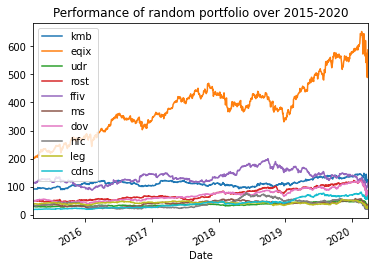

In [54]:
#obtain price data for test period
testPrices = ffn.get(randomTickers,start='2015-03-26', end='2020-03-26')
ax = testPrices.plot(title="Performance of random portfolio over 2015-2020")

Now we can calulate annualized return, volatility and sharpe ratio for the unweighted and weighted portfolios

In [55]:
#https://towardsdatascience.com/optimizing-portfolios-with-modern-portfolio-theory-using-python-60ce9a597808
print("Equi-weighted portfolio weights:")
print(np.full(10,.1), "\n")
print("Optimized portfolio weights:")
print(list(cleaned_weights.values()), "\n")

opt_weights = list(cleaned_weights.values())
weights_arr = [np.full(10,.1), opt_weights]
returns_arr = []
volatility_arr = []

print(" --- Results --- ")
for weights in weights_arr:
  returns = prices.pct_change()
  
  # mean daily return and covariance of daily returns
  mean_daily_returns = returns.mean()
  cov_matrix = returns.cov()
  
  # portfolio weights
  weights = np.asarray(weights)
  
  portfolio_return = round(np.sum(mean_daily_returns * weights) * 252,2)
  portfolio_std_dev = round(np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252),2)

  returns_arr.append(portfolio_return)
  volatility_arr.append(portfolio_std_dev)

  if(weights[0] == .1):
    print("Equal weighted portfolio stats:")
  else:
    print("Optimized portfolio stats:")
  print("Annualised return: " + str(portfolio_return))
  print("Volatility: " + str(portfolio_std_dev) + "\n")

print("Percent change in return after optimization: " + str(((returns_arr[1] - returns_arr[0])/returns_arr[0])))
print("Percent change in volatility after optimization: " + str(((volatility_arr[1] - volatility_arr[0])/volatility_arr[0])))

Equi-weighted portfolio weights:
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 

Optimized portfolio weights:
[0.15636, 0.09254, 0.06881, 0.29121, 0.00208, 0.0, 0.00677, 0.17926, 0.0929, 0.11006] 

 --- Results --- 
Equal weighted portfolio stats:
Annualised return: 0.22
Volatility: 0.2

Optimized portfolio stats:
Annualised return: 0.26
Volatility: 0.18

Percent change in return after optimization: 0.18181818181818185
Percent change in volatility after optimization: -0.10000000000000009


# **--- Optimization Results ---**

**Percent change in returns:** 58.8%

**Percent change in risk:** -5%

As expected, the portfolio optimization not only increased annualized returns, but also slightly decreased volitility.

Now we can graph the performance of the two portfolios with respect to the individual securities to visualize their performance.

In [93]:
#unweighted prices can be found by averaging the daily prices of all stocks in the portfolio
uw_portfolio = testPrices.mean(axis=1)

#random_tickers_lower = [x.lower() for x in randomTickers]
#print(random_tickers_lower)

"""

Basically now I dont know how to properly multiply the opt_weights vector by row
with the price data in the dataframe. I've tried converting the data to a series first
(see here: https://stackoverflow.com/questions/13166842/pandas-dataframe-multiply-with-a-series)
but no luck.

"""

def multiplyWithPrice(row, weights):
  #print(row)
  #print(row.name)
  #print(row.values)
  #print(weights)
  #print(weights[row.name])
  modifiedRow = []
  for i in (0, len(row.values)-1):
    row.values[i] = row.values[i]*weights[i]
    #modifiedRow.append(row[i]*weights[row.name])
  #return modifiedRow
  return row

#print(cleaned_weights)
opt_weights_ser = pd.Series(opt_weights)
#print(opt_weights_ser)
#print(uw_portfolio)
#print(testPrices)
#w_portfolio = testPrices
#multiplyWithPrice(column, cleaned_weights)
w_portfolio = testPrices.apply(lambda row: multiplyWithPrice(row, opt_weights_ser), axis=1)
print(w_portfolio)

#add portfolio data to price data
#testPrices['uw_portfolio'] = uw_portfolio
#testPrices['w_portfolio'] = w_portfolio

#plot new data
#ax = testPrices.plot(title="Performance of random portfolio over 2015-2020")



                 kmb        eqix        udr  ...        hfc        leg      cdns
Date                                         ...                                
2015-03-26  2.216749  197.321487  28.519485  ...  34.284805  38.268211  0.218038
2015-03-27  2.217791  198.940857  28.637711  ...  33.447353  38.608677  0.219007
2015-03-30  2.246355  202.829102  29.051533  ...  34.487820  39.144913  0.223367
2015-03-31  2.233220  201.642746  28.739054  ...  34.064854  39.230015  0.223367
2015-04-01  2.227799  202.283508  28.485693  ...  34.149456  38.829975  0.222762
...              ...         ...        ...  ...        ...        ...       ...
2020-03-20  2.891763  506.519989  32.029999  ...  22.280001  23.840000  0.667195
2020-03-23  2.746539  489.140015  30.040001  ...  18.660000  22.469999  0.676644
2020-03-24  2.869759  545.890015  30.910000  ...  19.309999  26.490000  0.767250
2020-03-25  2.844822  553.919983  32.889999  ...  21.559999  27.620001  0.743145
2020-03-26  3.031852  587.58